In [1]:
from __future__ import print_function
from pylab import *
from casadi import *
from casadi.tools import *  # for dotdraw
from IPython.display import Image, display
%matplotlib inline

def view_dot(graph):
   plt = Image(graph.create_png())
   display(plt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



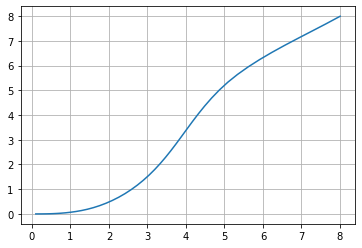

In [2]:
T = 10. # Time horizon
N = 100 # number of control intervals

# Declare model variables
x1 = MX.sym('x1')
x2 = MX.sym('x2')
phi = MX.sym('phi')
v = MX.sym('v')
d = MX.sym('d')
x = vertcat(x1, x2, phi, v, d)
a = MX.sym('a')
dd = MX.sym('dd')
u = vertcat(a, dd)

alpha = MX.sym('v')
beta = MX.sym('d')

L_f = 0.76

# Model equations
xdot = vertcat(v*cos(phi), v*sin(phi), v*d/L_f, a, dd)


# Objective term
L = alpha*(x1-x2)**2 + beta*(v-10)**2
Lf = Function('Lf', [alpha, beta, x, u], [L])


# Formulate discrete time dynamics
# if False:
   # CVODES from the SUNDIALS suite
#   dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
#   opts = {'tf':T/N}
#   F = integrator('F', 'cvodes', dae, opts)

'''
f = Function('f', [x, u], [xdot])
Lf = Function('Lf', [x, u], [L])

dae = {'x':x, 'p':u, 'ode':f(x,u), 'quad':Lf(x,u)}
opts = {'tf':T/N, "simplify": True, "number_of_finite_elements": 4}
f = integrator('f', 'rk', dae, opts)
'''

DT = T/N
f = Function('f', [x, u], [xdot, L])
X0 = MX.sym('X0', 5)
U = MX.sym('U', 2)
X = X0
Q = 0


k1, k1_q = f(X, U)
X=X+DT*k1
Q = k1_q
F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])

def loop(x_val,y_val,phi_val,v_val,d_val,last_a):
    # Start with an empty NLP
    w=[]
    w0 = []
    lbw = []
    ubw = []
    J = 0
    g=[]
    lbg = []
    ubg = []

    # "Lift" initial conditions
    Xk = MX.sym('X0', 5)
    w += [Xk]
    lbw += [x_val,y_val,phi_val,v_val,d_val]
    ubw += [x_val,y_val,phi_val,v_val,d_val]
    w0 += [x_val,y_val,phi_val,v_val,d_val]

    #Xk = MX([x_val, y_val, phi_val, v_val,d_val])
    # Formulate the NLP
    for k in range(N):
        # New NLP variable for the control
        Uk = MX.sym('U_' + str(k), 2)
        w   += [Uk]
        lbw += [-1,-0.2] # 25-degrees in radians
        ubw += [1,0.2]
        w0  += [last_a,0]

        # Integrate till the end of the interval
        Fk = F(x0=Xk, p=Uk)
        Xk_end = Fk['xf']
        J=J+Lf(10,1,Xk,Uk)

        # New NLP variable for state at end of interval
        Xk = MX.sym('X_' + str(k+1), 5)
        w   += [Xk]
        lbw += [0, -inf, -inf, 0.0, -0.43]
        ubw += [  inf,  inf, inf, inf, 0.43]
        w0  += [0, 0, 0, 0, 0]

        # Add equality constraint
        g   += [Xk_end-Xk]
        lbg += [0, 0, 0, 0, 0]
        ubg += [0, 0, 0, 0, 0]

    # Create an NLP solver
    prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = nlpsol('solver', 'ipopt', prob, opts)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)


    w_opt = sol['x'].full().flatten()

    # Plot the solution
    x1_opt = w_opt[0::7]
    x2_opt = w_opt[1::7]
    u1_opt = w_opt[5::7]
    u2_opt = w_opt[6::7]
    return u1_opt[0],u2_opt[0],x1_opt,x2_opt

import numpy as np

def move(state, a, dd, dt):
    x1,x2,phi,v,d = state
    g = [v*np.cos(phi), v*np.sin(phi), v*d/L_f, a, dd]
    return [state[i] + g[i]*dt for i in range(5)]
        
M = 50
past_states = np.zeros((M,5))
state = [0.1,0.0,0.0,0.0,0.0]

a_hist = []
d_hist = []
x = []
y = []
opt_a = 0.5
for epoch in range(M):
    past_states[epoch,:] = np.array(state)
    opt_a,opt_dd,x,y = loop(*state, opt_a)
    a_hist.append(opt_a)
    d_hist.append(opt_dd)
    state = move(state, opt_a, opt_dd, DT)

plt.plot(past_states[:,0], past_states[:,1])
#plt.plot(x,y)
plt.grid(True)
plt.show()

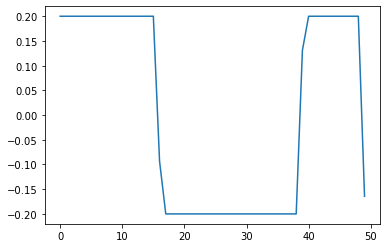

In [3]:
plt.plot(d_hist)

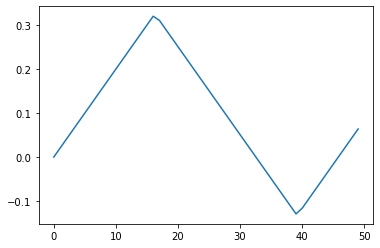

In [4]:
plt.plot(past_states[:,4])